# Libraries

In [117]:
# import relevant libraries
!pip install ondemand
!pip install py_vollib
import py_vollib 
import ondemand
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats
from datetime import datetime
from statsmodels.formula.api import ols
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics as sklMetrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from py_vollib.black_scholes_merton  import black_scholes_merton as bsm
from py_vollib.black_scholes_merton.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes_merton.greeks.analytical import delta 
from py_vollib.black_scholes_merton.greeks.analytical import gamma
from py_vollib.black_scholes_merton.greeks.analytical import rho
from py_vollib.black_scholes_merton.greeks.analytical import theta
from py_vollib.black_scholes_merton.greeks.analytical import vega
plt.style.use('seaborn')
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Functions

In [118]:
# function to syntesize historical greeks and IV
def greek_val(flag, S, K, t, r, sigma):
    """
    price (float) – the Black-Scholes-Merton (American) option price
    S (float) – underlying asset price
    sigma (float) – annualized standard deviation, or volatility
    K (float) – strike price
    t (float) – time to expiration in years
    r (float) – risk-free interest rate
    flag (str) – ‘c’ or ‘p’ for call or put.
    """
    flag = 'c'
    price = bsm(flag, S, K, t, r, sigma, 0)
    imp_v = iv(price, S, K, t, r, 0, flag)
    delta_calc = delta(flag, S, K, t, r, sigma, 0)
    gamma_calc = gamma(flag, S, K, t, r, sigma, 0)
    rho_calc = rho(flag, S, K, t, r, sigma, 0)
    theta_calc = theta(flag, S, K, t, r, sigma, 0)
    vega_calc = vega(flag, S, K, t, r, sigma, 0)
    return np.array([ price, imp_v ,theta_calc, delta_calc ,rho_calc ,vega_calc ,gamma_calc])

In [119]:
# function for correlation matrix
def CorrMtx(df, dropDuplicates = True):
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.set_style(style = 'white')
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

In [120]:
# WIP mapping functions
def call_map(x):
    if x > 5:
        return 'BUY'
    elif x < -10:
        return 'WRITE'
    else:
        return 'HOLD'
def put_map(x):
    if x > 0:
        return 'WRITE'
    elif x < 0:
        return 'BUY'
    else:
        return 'HOLD'

In [121]:
# read-in dataframes
options_355c = pd.read_csv('hgh1|355c_daily_historical-data-02-04-2021.csv')[1:-1]
options_360c = pd.read_csv('hgh1|360c_daily_historical-data-02-04-2021.csv')[1:-1]
options_370c = pd.read_csv('hgh1|370c_daily_historical-data-02-04-2021.csv')[1:-1]
underlying_df = pd.read_csv('hgh21_daily_historical-data-02-05-2021.csv')[2:449]
options_df = options_355c
underlying_df.reset_index(drop=True, inplace=True)
options_df.reset_index(drop=True, inplace=True)

In [122]:
underlying_df.head()

,Time,Open,High,Low,Last,Change,%Chg,Volume,Open Int
0,02/03/2021,3.5275,3.5730,3.5035,3.5655,0.0410,+1.16%,70465.0,145718.0
1,02/02/2021,3.5510,3.5690,3.5000,3.5245,-0.0215,-0.61%,85090.0,145643.0
2,02/01/2021,3.5555,3.5850,3.5235,3.5460,-0.0100,-0.28%,78820.0,147824.0
3,01/29/2021,3.5745,3.6125,3.5320,3.5560,-0.0220,-0.61%,94560.0,149237.0
4,01/28/2021,3.5470,3.5985,3.4910,3.5780,0.0205,+0.58%,115390.0,149943.0


In [123]:
options_df.head()

,Time,Open,High,Low,Last,Change,%Chg,Volume,Open Int
0,02/03/2021,0.0860,0.0860,0.0660,0.0840,0.0110,+15.07%,10.0,422.0
1,02/02/2021,0.0730,0.0730,0.0730,0.0730,-0.0065,-8.18%,72.0,414.0
2,02/01/2021,0.0760,0.0795,0.0760,0.0795,-0.0135,-14.52%,115.0,456.0
3,01/29/2021,0.1025,0.1230,0.0840,0.0930,-0.0100,-9.71%,2.0,401.0
4,01/28/2021,0.1100,0.1120,0.0625,0.1030,0.0170,+19.77%,14.0,401.0


In [124]:

greeks_df = pd.DataFrame([greek_val('c',
                                    underlying_df.iloc[i]['Last'],
                                    355,
                                    (25+i)/365,
                                    2,
                                    underlying_df['Last'][i:].std()
                                   )
                          for i in range(len(underlying_df))],
                         columns=["price",
                                  "imp_v",
                                  "theta",
                                  "delta",
                                  "rho",
                                  "vega",
                                  "gamma"
                                 ]
                        )

In [125]:
greeks_df

,price,imp_v,theta,delta,rho,vega,gamma
0,0.000000e+00,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000e+00,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,0.000000e+00,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,0.000000e+00,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,0.000000e+00,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,0.000000e+00,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,0.000000e+00,0.000000,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


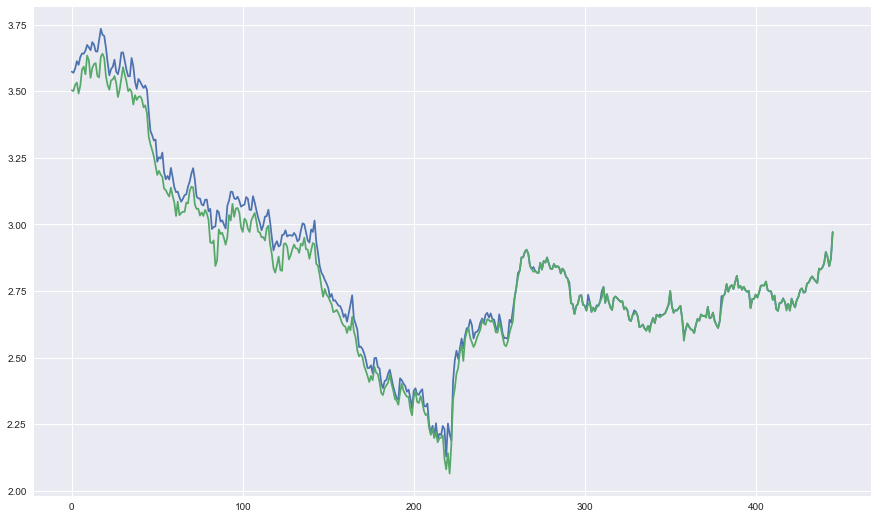

In [136]:
start = 0
end = -1
plt.figure(figsize=(15,9))
plt.plot(underlying_df.index[start:end], underlying_df['High'][start:end])
plt.plot(underlying_df.index[start:end], underlying_df['Low'][start:end])
#plt.plot(underlying_df.index[start:end], underlying_df['Last'][start:end])
#plt.plot(underlying_df.index[start:end], underlying_df['Open'][start:end])

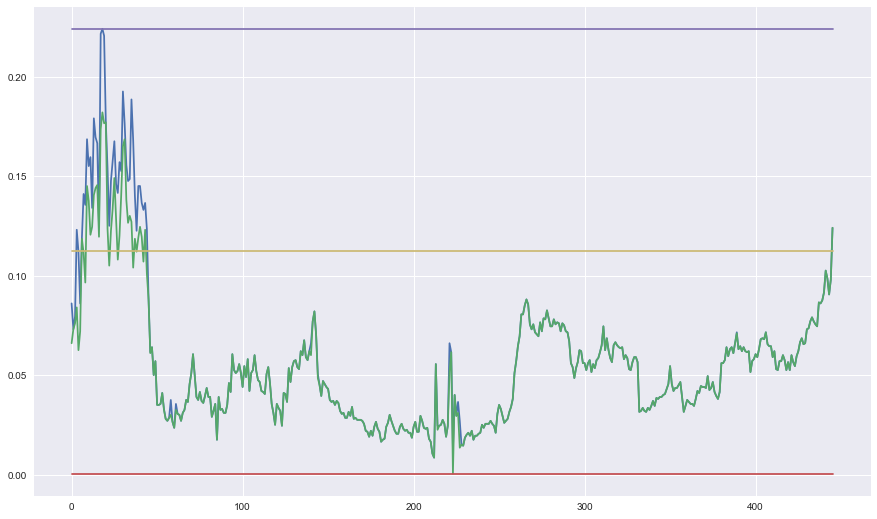

In [165]:
start = 0
end = -1
low_point = min(options_df['Low'])
high_point = max(options_df['High'])
mid_point = (high_point + low_point)/2
plt.figure(figsize=(15,9))
plt.plot(options_df.index[start:end][::-1], options_df['High'][start:end][::-1])
plt.plot(options_df.index[start:end][::-1], options_df['Low'][start:end][::-1])
#plt.plot(options_df.index[start:end][::-1], options_df['Last'][start:end][::-1])
#plt.plot(options_df.index[start:end][::-1], options_df['Open'][start:end][::-1])
plt.plot(options_df.index[start:end][::-1], [low_point for i in range(len(options_df.index[start:end]))])
plt.plot(options_df.index[start:end][::-1], [high_point for i in range(len(options_df.index[start:end]))])
plt.plot(options_df.index[start:end][::-1], [mid_point for i in range(len(options_df.index[start:end]))])

In [85]:
underlying_df['uInterval'] = underlying_df['High'] - underlying_df['Low']
options_df['oInterval'] = options_df['High'] - options_df['Low']

underlying_df['uClose'] = underlying_df['Last']
options_df['oClose'] = options_df['Last']

underlying_df['uOI'] = underlying_df['Open Int']
options_df['oOI'] = options_df['Open Int']

underlying_df['uVolume'] = underlying_df['Volume']
options_df['oVolume'] = options_df['Volume']

underlying_df['uChange'] = underlying_df['Change']
options_df['oChange'] = options_df['Change']

underlying_df = underlying_df.drop(columns=['Open', 'High', 'Low', 'Last', 'Open Int', 'Volume', 'Change', '%Chg'])
options_df = options_df.drop(columns=['Open', 'High', 'Low', 'Last', 'Open Int', 'Volume', 'Change', '%Chg', 'Time'])

In [86]:
underlying_df.head()

,Time,uInterval,uClose,uOI,uVolume,uChange
0,02/03/2021,0.0695,3.5655,145718.0,70465.0,0.0410
1,02/02/2021,0.0690,3.5245,145643.0,85090.0,-0.0215
2,02/01/2021,0.0615,3.5460,147824.0,78820.0,-0.0100
3,01/29/2021,0.0805,3.5560,149237.0,94560.0,-0.0220
4,01/28/2021,0.1075,3.5780,149943.0,115390.0,0.0205


In [87]:
options_df.head()

,oInterval,oClose,oOI,oVolume,oChange
0,0.0200,0.0840,422.0,10.0,0.0110
1,0.0000,0.0730,414.0,72.0,-0.0065
2,0.0035,0.0795,456.0,115.0,-0.0135
3,0.0390,0.0930,401.0,2.0,-0.0100
4,0.0495,0.1030,401.0,14.0,0.0170


In [88]:
und_opt_df = pd.concat([underlying_df,options_df], axis=1)
und_opt_df = und_opt_df.set_index('Time')
und_opt_df.head()

,uInterval,uClose,uOI,uVolume,uChange,oInterval,oClose,oOI,oVolume,oChange
Time,,,,,,,,,,
02/03/2021,0.0695,3.5655,145718.0,70465.0,0.0410,0.0200,0.0840,422.0,10.0,0.0110
02/02/2021,0.0690,3.5245,145643.0,85090.0,-0.0215,0.0000,0.0730,414.0,72.0,-0.0065
02/01/2021,0.0615,3.5460,147824.0,78820.0,-0.0100,0.0035,0.0795,456.0,115.0,-0.0135
01/29/2021,0.0805,3.5560,149237.0,94560.0,-0.0220,0.0390,0.0930,401.0,2.0,-0.0100
01/28/2021,0.1075,3.5780,149943.0,115390.0,0.0205,0.0495,0.1030,401.0,14.0,0.0170


In [89]:
final_df = und_opt_df
final_df['target'] = final_df['oChange'].shift()
final_df.fillna(method='bfill', inplace=True)
print(final_df.shape)
final_df.head()

(447, 11)


,uInterval,uClose,uOI,uVolume,uChange,oInterval,oClose,oOI,oVolume,oChange,target
Time,,,,,,,,,,,
02/03/2021,0.0695,3.5655,145718.0,70465.0,0.0410,0.0200,0.0840,422.0,10.0,0.0110,0.0110
02/02/2021,0.0690,3.5245,145643.0,85090.0,-0.0215,0.0000,0.0730,414.0,72.0,-0.0065,0.0110
02/01/2021,0.0615,3.5460,147824.0,78820.0,-0.0100,0.0035,0.0795,456.0,115.0,-0.0135,-0.0065
01/29/2021,0.0805,3.5560,149237.0,94560.0,-0.0220,0.0390,0.0930,401.0,2.0,-0.0100,-0.0135
01/28/2021,0.1075,3.5780,149943.0,115390.0,0.0205,0.0495,0.1030,401.0,14.0,0.0170,-0.0100


In [90]:
final_df['interval_diff'] = abs(final_df['uInterval'] - final_df['oInterval'])
final_df['prev_int_diff'] = final_df['interval_diff'].shift(-1)
final_df.fillna(method='ffill', inplace=True)
final_df['interval_dif_chg'] = final_df['interval_diff'] - final_df['prev_int_diff']
final_df.drop(columns=['interval_diff', 'prev_int_diff', 'uInterval', 'oInterval'], inplace=True)
final_df

,uClose,uOI,uVolume,uChange,oClose,oOI,oVolume,oChange,target,interval_dif_chg
Time,,,,,,,,,,
02/03/2021,3.5655,145718.0,70465.0,0.0410,0.0840,422.0,10.0,0.0110,0.0110,-1.950000e-02
02/02/2021,3.5245,145643.0,85090.0,-0.0215,0.0730,414.0,72.0,-0.0065,0.0110,1.100000e-02
02/01/2021,3.5460,147824.0,78820.0,-0.0100,0.0795,456.0,115.0,-0.0135,-0.0065,1.650000e-02
01/29/2021,3.5560,149237.0,94560.0,-0.0220,0.0930,401.0,2.0,-0.0100,-0.0135,-1.650000e-02
01/28/2021,3.5780,149943.0,115390.0,0.0205,0.1030,401.0,14.0,0.0170,-0.0100,-3.550000e-02
01/27/2021,3.5575,147272.0,105183.0,-0.0620,0.0860,407.0,0.0,-0.0325,0.0170,3.300000e-02
01/26/2021,3.6195,152033.0,60310.0,-0.0100,0.1185,407.0,10.0,-0.0115,-0.0325,4.150000e-02
01/25/2021,3.6295,152397.0,63752.0,0.0035,0.1300,407.0,10.0,-0.0055,-0.0115,-3.050000e-02
01/22/2021,3.6260,152671.0,82146.0,-0.0215,0.1355,406.0,5.0,-0.0155,-0.0055,3.300000e-02


In [91]:
final_df['volume_diff'] = abs(final_df['uVolume'] - final_df['oVolume'])
final_df['prev_vol_diff'] = final_df['volume_diff'].shift(-1)
final_df.fillna(method='ffill', inplace=True)
final_df['volume_dif_chg'] = final_df['volume_diff'] - final_df['prev_vol_diff']
final_df.drop(columns=['volume_diff', 'prev_vol_diff', 'uVolume', 'oVolume'], inplace=True)
final_df

,uClose,uOI,uChange,oClose,oOI,oChange,target,interval_dif_chg,volume_dif_chg
Time,,,,,,,,,
02/03/2021,3.5655,145718.0,0.0410,0.0840,422.0,0.0110,0.0110,-1.950000e-02,-14563.0
02/02/2021,3.5245,145643.0,-0.0215,0.0730,414.0,-0.0065,0.0110,1.100000e-02,6313.0
02/01/2021,3.5460,147824.0,-0.0100,0.0795,456.0,-0.0135,-0.0065,1.650000e-02,-15853.0
01/29/2021,3.5560,149237.0,-0.0220,0.0930,401.0,-0.0100,-0.0135,-1.650000e-02,-20818.0
01/28/2021,3.5780,149943.0,0.0205,0.1030,401.0,0.0170,-0.0100,-3.550000e-02,10193.0
01/27/2021,3.5575,147272.0,-0.0620,0.0860,407.0,-0.0325,0.0170,3.300000e-02,44883.0
01/26/2021,3.6195,152033.0,-0.0100,0.1185,407.0,-0.0115,-0.0325,4.150000e-02,-3442.0
01/25/2021,3.6295,152397.0,0.0035,0.1300,407.0,-0.0055,-0.0115,-3.050000e-02,-18399.0
01/22/2021,3.6260,152671.0,-0.0215,0.1355,406.0,-0.0155,-0.0055,3.300000e-02,28101.0


In [92]:
final_df['oi_diff'] = abs(final_df['uOI'] - final_df['oOI'])
final_df['prev_oi_diff'] = final_df['oi_diff'].shift(-1)
final_df.fillna(method='ffill', inplace=True)
final_df['oi_dif_chg'] = final_df['oi_diff'] - final_df['prev_oi_diff']
final_df.drop(columns=['oi_diff', 'prev_oi_diff', 'uOI', 'oOI'], inplace=True)
final_df

,uClose,uChange,oClose,oChange,target,interval_dif_chg,volume_dif_chg,oi_dif_chg
Time,,,,,,,,
02/03/2021,3.5655,0.0410,0.0840,0.0110,0.0110,-1.950000e-02,-14563.0,67.0
02/02/2021,3.5245,-0.0215,0.0730,-0.0065,0.0110,1.100000e-02,6313.0,-2139.0
02/01/2021,3.5460,-0.0100,0.0795,-0.0135,-0.0065,1.650000e-02,-15853.0,-1468.0
01/29/2021,3.5560,-0.0220,0.0930,-0.0100,-0.0135,-1.650000e-02,-20818.0,-706.0
01/28/2021,3.5780,0.0205,0.1030,0.0170,-0.0100,-3.550000e-02,10193.0,2677.0
01/27/2021,3.5575,-0.0620,0.0860,-0.0325,0.0170,3.300000e-02,44883.0,-4761.0
01/26/2021,3.6195,-0.0100,0.1185,-0.0115,-0.0325,4.150000e-02,-3442.0,-364.0
01/25/2021,3.6295,0.0035,0.1300,-0.0055,-0.0115,-3.050000e-02,-18399.0,-275.0
01/22/2021,3.6260,-0.0215,0.1355,-0.0155,-0.0055,3.300000e-02,28101.0,-2759.0


### futures closing prices

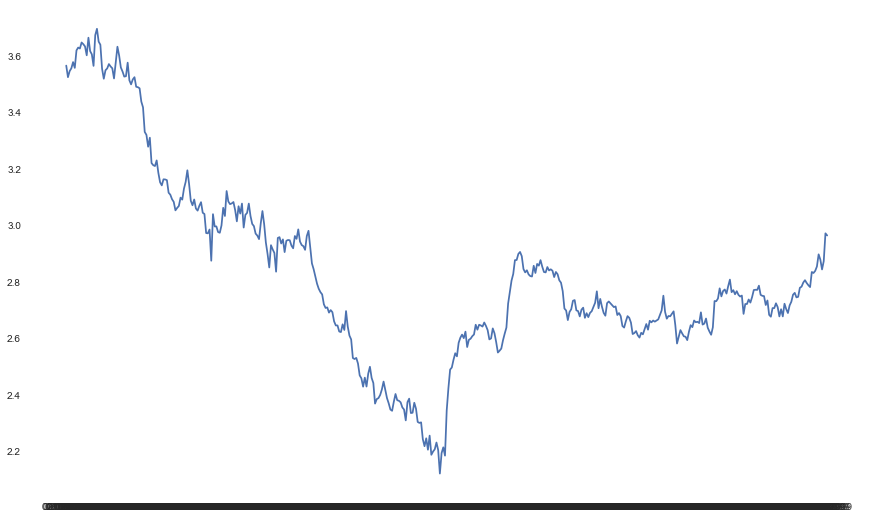

In [115]:
# graph of prices of last hundred trades
plt.figure(figsize=(15,9))
plt.plot(final_df.index, final_df['uClose'])

### 1st derivative of futures closing price

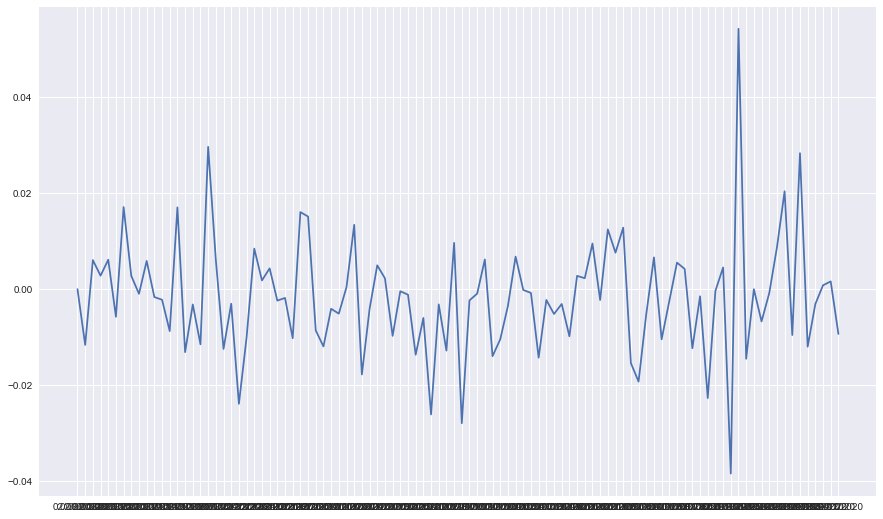

In [94]:
# graph of first derivative of last hundred trades
plt.figure(figsize=(15,9))
plt.plot(final_df.index[:100], final_df['uClose'][:100].diff().fillna(0)/final_df['uClose'][:100])

### options closing prices

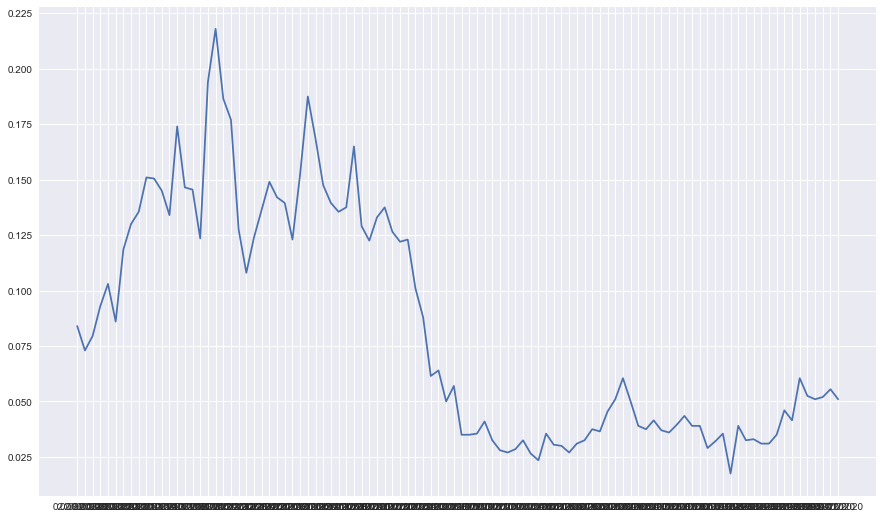

In [95]:
# graph of prices of last hundred trades
plt.figure(figsize=(15,9))
plt.plot(final_df.index[:100], final_df['oClose'][:100])

### 1st derivative of options closing price

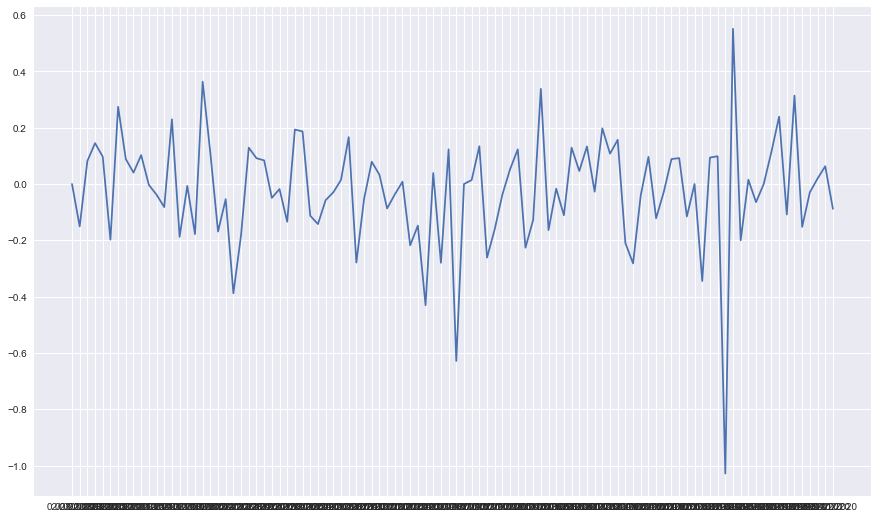

In [96]:
# graph of first derivative of last hundred trades
plt.figure(figsize=(15,9))
plt.plot(final_df.index[:100], final_df['oClose'][:100].diff().fillna(0)/final_df['oClose'][:100])

In [97]:
scaler = MinMaxScaler()
scaler.fit(final_df)
scaled = scaler.transform(final_df)
scaled_df = pd.DataFrame(scaled, columns=final_df.columns)
scaled_df = scaled_df * 255
scaled_df['target'] = scaled_df['target'] - 128

In [98]:
#svd = TruncatedSVD()
#svd.fit(scaled_df)
#call_singular_values = svd.singular_values_
#transformed = svd.transform(scaled_calls)
#print('transformed:', transformed.shape)
#print('singular_values:', singular_values)
#transformed_df.head()

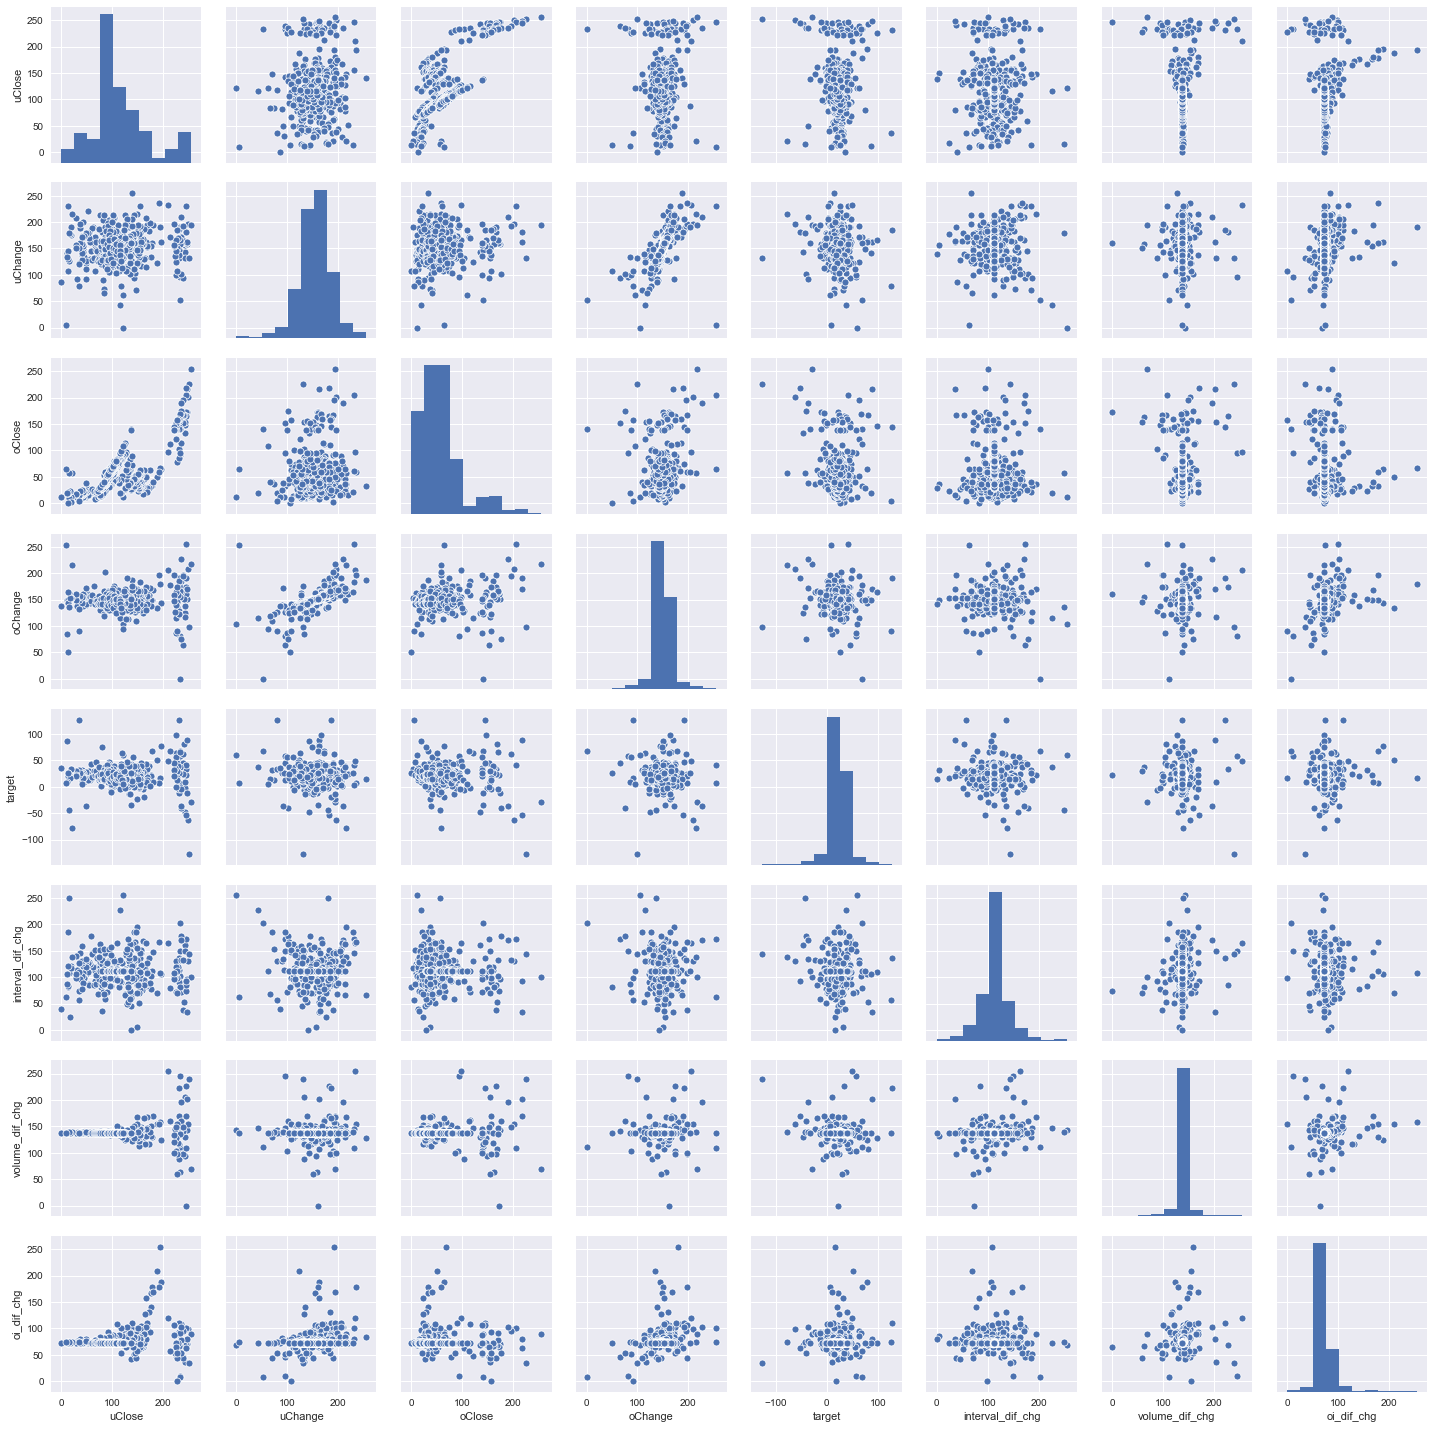

In [99]:
# visualize correlations
sns.pairplot(scaled_df)

In [100]:
# ordinary least squares
lr_model = ols(formula='target~oi_dif_chg+interval_dif_chg+oChange+oClose', data=scaled_df).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     5.634
Date:                Mon, 08 Feb 2021   Prob (F-statistic):           0.000198
Time:                        13:28:28   Log-Likelihood:                -1977.4
No. Observations:                 447   AIC:                             3965.
Df Residuals:                     442   BIC:                             3985.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           44.8037      8.550      5.240      0.000      28.001      61.606
oi_dif_chg           0.1066      0.052      2.045      0.041       0.004       0.209
interval_dif_chg    -0.0646      0.034     -1.878      0.061      -0.132       0.003
oChange             -0.1373      0.050     -2.732      0.007      -0.236      -0.039
oClose              -0.0614      0.024     -2.591      0.010      -0.108      -0.015
==============================================================================
Omnibus:                       91.735   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1931.353
Skew:                          -0.079   Prob(JB):                         0.00
Kurtosis:                      13.182   Cond. No.                     1.89e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [101]:
# put correlation matrix
corr = scaled_df.corr()
corr

,uClose,uChange,oClose,oChange,target,interval_dif_chg,volume_dif_chg,oi_dif_chg
uClose,1.000000,0.103552,0.754591,0.043910,-0.018718,-0.003960,0.030197,0.136390
uChange,0.103552,1.000000,0.092074,0.671042,-0.094946,-0.061596,0.029399,0.275125
oClose,0.754591,0.092074,1.000000,0.130996,-0.152468,-0.003236,0.010767,-0.115261
oChange,0.043910,0.671042,0.130996,1.000000,-0.110859,-0.098064,0.001911,0.330694
target,-0.018718,-0.094946,-0.152468,-0.110859,1.000000,-0.078723,-0.033517,0.075141
interval_dif_chg,-0.003960,-0.061596,-0.003236,-0.098064,-0.078723,1.000000,0.199700,-0.048852
volume_dif_chg,0.030197,0.029399,0.010767,0.001911,-0.033517,0.199700,1.000000,0.074739
oi_dif_chg,0.136390,0.275125,-0.115261,0.330694,0.075141,-0.048852,0.074739,1.000000


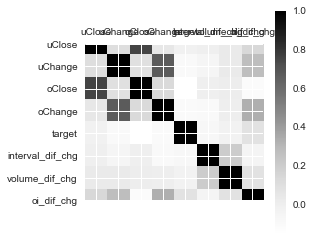

In [102]:
# visualization of call correlation matrix
plt.matshow(corr)
plt.xticks(range(len(final_df.columns)), final_df.columns)
plt.yticks(range(len(final_df.columns)), final_df.columns)
plt.colorbar()
plt.show()

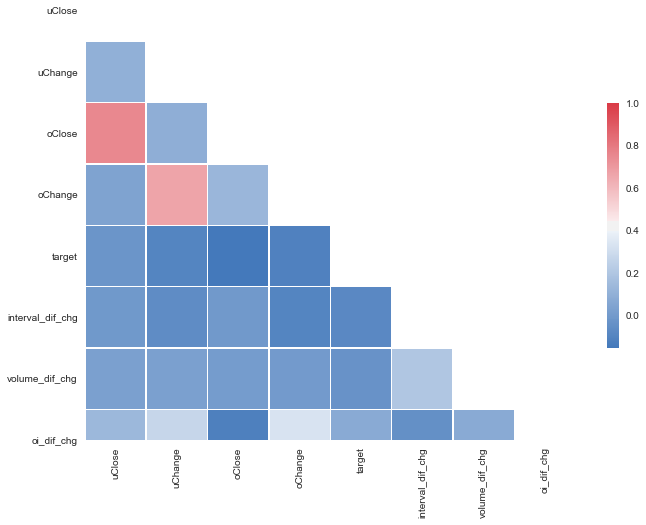

In [103]:
# visualization of call correlation matrix
CorrMtx(corr, dropDuplicates = True)

In [104]:
# call map functions based on "Change" up/same/down
mapped_df = pd.concat([scaled_df['oi_dif_chg'], scaled_df['interval_dif_chg'], scaled_df['oChange'], scaled_df['oClose'], scaled_df['target'].apply(call_map)], axis=1)
mapped_df.head()

,oi_dif_chg,interval_dif_chg,oChange,oClose,target
0,73.868476,90.336323,173.1875,91.897375,BUY
1,45.001539,125.213004,136.0000,78.508353,BUY
2,53.782009,131.502242,121.1250,86.420048,BUY
3,63.753271,93.766816,128.5625,102.852029,HOLD
4,108.022015,72.040359,185.9375,115.023866,HOLD


standard deviation: 20.713861245809156
mean: 21.684144295302012


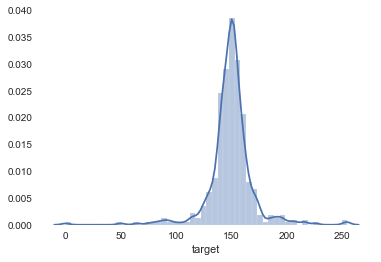

In [105]:
print('standard deviation:', scaled_df['target'].std())
print('mean:', scaled_df['target'].mean())
sns.distplot(scaled_df['target']+128)

standard deviation: 19.828243768996902
mean: 77.24337305579363


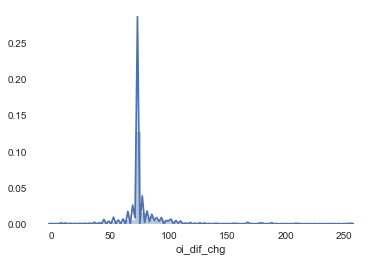

In [106]:
print('standard deviation:', mapped_df['oi_dif_chg'].std())
print('mean:', mapped_df['oi_dif_chg'].mean())
sns.distplot(mapped_df['oi_dif_chg'])

standard deviation: 28.098286111107026
mean: 112.76115809432059


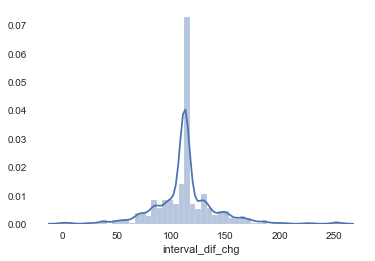

In [107]:
print('standard deviation:', mapped_df['interval_dif_chg'].std())
print('mean:', mapped_df['interval_dif_chg'].mean())
sns.distplot(mapped_df['interval_dif_chg'])

standard deviation: 20.68416266373639
mean: 149.63660514541388


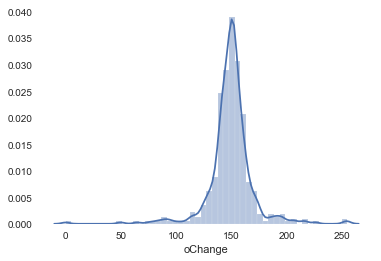

In [108]:
print('standard deviation:', mapped_df['oChange'].std())
print('mean:', mapped_df['oChange'].mean())
sns.distplot(mapped_df['oChange'])

standard deviation: 41.52454769637575
mean: 57.5398439877625


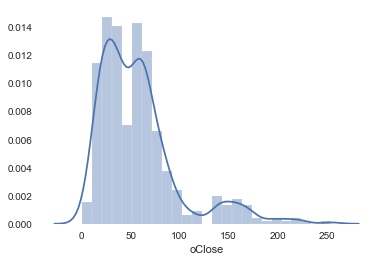

In [109]:
print('standard deviation:', mapped_df['oClose'].std())
print('mean:', mapped_df['oClose'].mean())
sns.distplot(mapped_df['oClose'])

In [110]:
mapped_df['target'].value_counts()

BUY      403
HOLD      26
WRITE     18
Name: target, dtype: int64

In [114]:
# resample
buy_df = mapped_df.loc[mapped_df['target']=='BUY'].sample(n=56, replace=True)
hold_df = mapped_df.loc[mapped_df['target']=='HOLD'].sample(n=44, replace=True)
write_df = mapped_df.loc[mapped_df['target']=='WRITE']
resampled_df = pd.concat([buy_df,hold_df,write_df], axis=0)
resampled_df = resampled_df.sample(frac=1).reset_index(drop=True)
print('--before resample--')
print('mapped_df.shape:', mapped_df.shape)
print(mapped_df['target'].value_counts())
print('--after resample--')
print('resampled_df.shape:', resampled_df.shape)
print(resampled_df['target'].value_counts())
print()
print('resampled dataframe (to be exported)'.upper())
resampled_df

--before resample--
mapped_df.shape: (447, 5)
BUY      403
HOLD      26
WRITE     18
Name: target, dtype: int64
--after resample--
resampled_df.shape: (118, 5)
BUY      56
HOLD     44
WRITE    18
Name: target, dtype: int64

RESAMPLED DATAFRAME (TO BE EXPORTED)


,oi_dif_chg,interval_dif_chg,oChange,oClose,target
0,72.991738,112.634529,146.6250,68.770883,HOLD
1,72.978652,112.634529,149.8125,87.637232,HOLD
2,64.734695,168.665919,160.4375,32.863962,HOLD
3,108.022015,72.040359,185.9375,115.023866,HOLD
4,34.493765,144.652466,98.8125,225.787589,WRITE
5,73.004824,112.634529,143.4375,61.467780,BUY
6,72.991738,112.634529,143.4375,42.601432,BUY
7,72.991738,112.634529,150.8750,43.818616,BUY
8,72.991738,112.634529,142.3750,39.558473,BUY
9,72.952481,112.634529,150.8750,85.202864,BUY


In [ ]:
# export the call and put dfs
mapped_df.to_csv('/Users/lucas/Desktop/futures_options/hgh1-355c.csv', index=False)

# Beginning of Attempted Barchart OnDemand Trial

In [ ]:
API_KEY = 'c16656551be9cbc04c97057b63340ff0'
#od = ondemand.OnDemandClient(api_key=API_KEY)
od = ondemand.OnDemandClient(api_key=API_KEY, end_point='https://ondemand.websol.barchart.com/service?wsdl')
# if you want data in a format other than json. xml also supported
#od = ondemand.OnDemandClient(api_key='CHANGE_ME', format='csv')
# get quote data for Apple and Microsoft
#quotes = od.quote('AAPL,MSFT')['results']
# result = client.service.getFuturesOptions('YOUR_API_KEY', 'ZC', 'ZCN18', 'ZCK210C,ZCK210P', 'CME', 'Call', 'premium,openInterest')
symbol = 'AAPL'  #@param {type: "string"}

resp = od.history(symbol, 'daily', startDate='20180601')['results']

prices = [bar['close'] for bar in resp]
dates = [datetime.strptime(bar['timestamp'][:19], '%Y-%m-%dT%H:%M:%S') for bar in resp]

data = pd.Series(prices, index=dates)

data.plot()

# Synthetic Greeks/IV

In [ ]:
"""
price (float) – the Black-Scholes option price
S (float) – underlying asset price
sigma (float) – annualized standard deviation, or volatility
K (float) – strike price
t (float) – time to expiration in years
r (float) – risk-free interest rate
flag (str) – ‘c’ or ‘p’ for call or put.
"""
"""
def greek_val(flag, S, K, t, r, sigma):
    price = bs(flag, S, K, t, r, sigma)
    imp_v = iv(price, S, K, t, r, flag)
    delta_calc = delta(flag, S, K, t, r, sigma)
    gamma_calc = gamma(flag, S, K, t, r, sigma)
    rho_calc = rho(flag, S, K, t, r, sigma)
    theta_calc = theta(flag, S, K, t, r, sigma)
    vega_calc = vega(flag, S, K, t, r, sigma)
    return np.array([ price, imp_v ,theta_calc, delta_calc ,rho_calc ,vega_calc ,gamma_calc])
"""
S = 8400
K = 8600
sigma = 16
r = 0.07
t = 1

call=greek_val('c', S, K, t, r, sigma)

put=greek_val('p', S, K, t, r, sigma)